In [13]:
#!/usr/bin/env python
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import ShuffleSplit
#from skopt.learning import ExtraTreesRegressor as opt_ETR
#from skopt.learning import RandomForestRegressor as opt_RFR
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.stats import norm
import os, sys
sys.dont_write_bytecode = True

import modules.conditions as conditions
import modules.setting as setting
import modules.converter as converter
import modules.analysis as analysis

import random
random.seed(1107)
np.random.seed(1107)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams["legend.markerscale"] = 2
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams.update({'mathtext.default':'regular'})


In [2]:
condition = conditions.calc_condition()
date, Reaction = condition['date'], condition['Reaction']
cand_pgm_num, cand_prm_num = condition['cand_pgm_num'], condition['cand_prm_num']
cand_add_num, cand_supp_num = condition['cand_add_num'], condition['cand_supp_num']
pgm_model, prm_model = condition['pgm_model'], condition['prm_model']
add_model, supp_model = condition['add_model'], condition['supp_model']
save_depth = condition['cut_size']
ML_model, Search_method = condition['ML_model'], condition['Search_method']
K_cluster = condition['K_cluster']

data_cols = setting.data_columns(condition)
cand_elem_cols, cand_wt_cols, cand_labels = data_cols['cand_elem'], data_cols['cand_wt'], data_cols['cand_labels']

desc_cols = setting.desc_columns(condition['Reaction'])
cand_cols_order = converter.cols_order(condition)

converted = converter.data_convert(condition, data_cols, desc_cols, sheet_name='data_sheet_name',
                                    select_desc=True, use_models=[], local=False, idx=None)
data = converted['data']
feat, target = converted['feat'], converted['target']

In [4]:
cand_data = f'results/{date}_{Reaction}_cand_sum_{ML_model}_prop{add_model}_{Search_method}.csv' # == results_csv_file_all
cand = converter.cand_separation(cand_data, condition)
cand = converter.cand_str(cand, condition, data_cols)

cand.drop_duplicates(subset=['Top catal.'], inplace=True)


cand_sep_data: (777600, 11)


In [5]:
cand

,Ad1,Ad1_wt%,Ad2,Ad2_wt%,Ad3,Ad3_wt%,Ad4,Ad4_wt%,Ad5,Ad5_wt%,ei,Top catal.
0,Mg,0.2,Rb,1.0,Nb,1.0,Te,0.0,Ta,0.0,0.063704,"Mg(0.2), Rb(1.0), Nb(1.0),"
100,Na,0.2,Rb,1.0,Nb,1.0,Cd,0.0,Sb,0.2,0.084615,"Na(0.2), Rb(1.0), Nb(1.0), Sb(0.2),"
105,Mg,0.2,Rb,1.0,Nb,1.0,Sb,0.0,Cs,0.2,0.081698,"Mg(0.2), Rb(1.0), Nb(1.0), Cs(0.2),"
112,Na,0.2,Rb,1.0,Nb,1.0,In,0.0,Te,0.2,0.073836,"Na(0.2), Rb(1.0), Nb(1.0), Te(0.2),"
118,Mg,0.2,Rb,1.0,Nb,1.0,Ag,0.0,Ba,0.2,0.067364,"Mg(0.2), Rb(1.0), Nb(1.0), Ba(0.2),"
...,...,...,...,...,...,...,...,...,...,...,...,...
777595,Tb,1.0,Ho,1.5,Tm,2.0,Yb,2.0,Lu,2.0,0.015271,"Tb(1.0), Ho(1.5), Tm(2.0), Yb(2.0), Lu(2.0),"
777596,Cs,1.0,Ce,1.5,Eu,2.0,Yb,2.0,W,2.0,0.015202,"Cs(1.0), Ce(1.5), Eu(2.0), Yb(2.0), W(2.0),"
777597,Cs,1.0,Ba,1.5,Nd,2.0,Eu,2.0,W,2.0,0.015102,"Cs(1.0), Ba(1.5), Nd(2.0), Eu(2.0), W(2.0),"
777598,Ce,1.0,Nd,1.5,Eu,2.0,Dy,2.0,Hf,2.0,0.015035,"Ce(1.0), Nd(1.5), Eu(2.0), Dy(2.0), Hf(2.0),"


In [6]:
### PLOT K-TOP CATALYST CANDIDATES ###
cvmodel, error = analysis.grid_search_CV(feat, target, split_type='KFold', split_num=10, use_model='ETR')
print('n_estimators=', cvmodel.best_params_['n_estimators'], 'bootstrap=', cvmodel.best_params_['bootstrap'])
model  = ExtraTreesRegressor(n_estimators=cvmodel.best_params_['n_estimators'], bootstrap=cvmodel.best_params_['bootstrap'], random_state=1107, n_jobs=-1)
model.fit(feat, target)

k = KMeans(n_clusters=K_cluster, random_state=1107)
cluster = k.fit_predict(cand.loc[:, cand_wt_cols]) ### <--- ！！！！！
cluster = pd.Series(cluster, index=cand.index, name='cluster')


Train ... RMSE: 0.037, MSE: 0.004, MAE: 0.025, R2: 0.995, RMSE detail (sd: 0.056, min:0.000, max:0.150)
Test ... RMSE: 0.380, MSE: 0.146, MAE: 0.308, R2: 0.820, RMSE detail (sd: 0.043, min:0.287, max:0.449)
n_estimators= 100 bootstrap= False


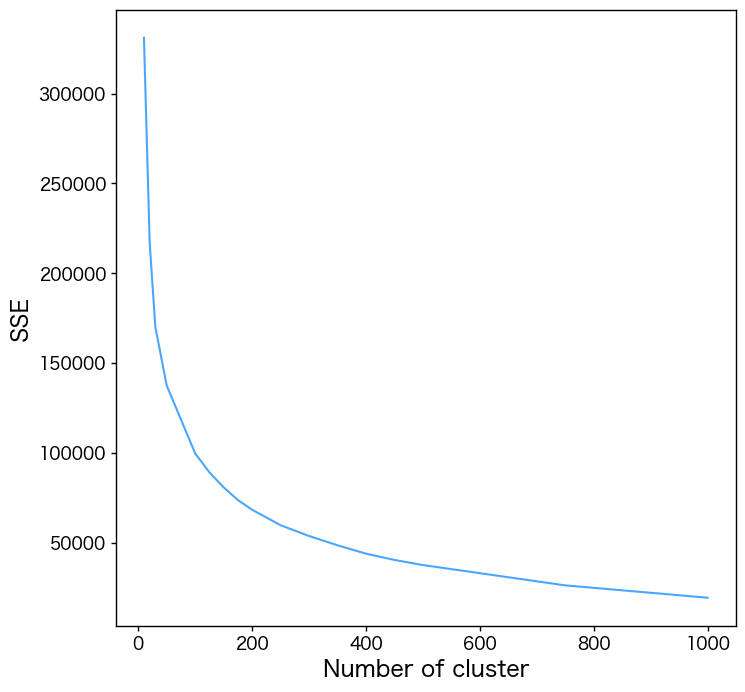

In [12]:
sse = {}
k_s = [10, 20, 30, 50, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500, 750, 1000]

for k in k_s:
    kmeans = KMeans(n_clusters=k).fit(cand.loc[:, cand_wt_cols])
    cand["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(facecolor='white', figsize=(8, 8))
plt.plot(list(sse.keys()), list(sse.values()), marker='o', color='dodgerblue', alpha=0.8)
plt.xlabel("Number of cluster", fontsize=16)
plt.ylabel("Distortion (SSE)", fontsize=16)
plt.savefig('results/elbow_analysis.png', dpi=600, bbox_inches='tight')

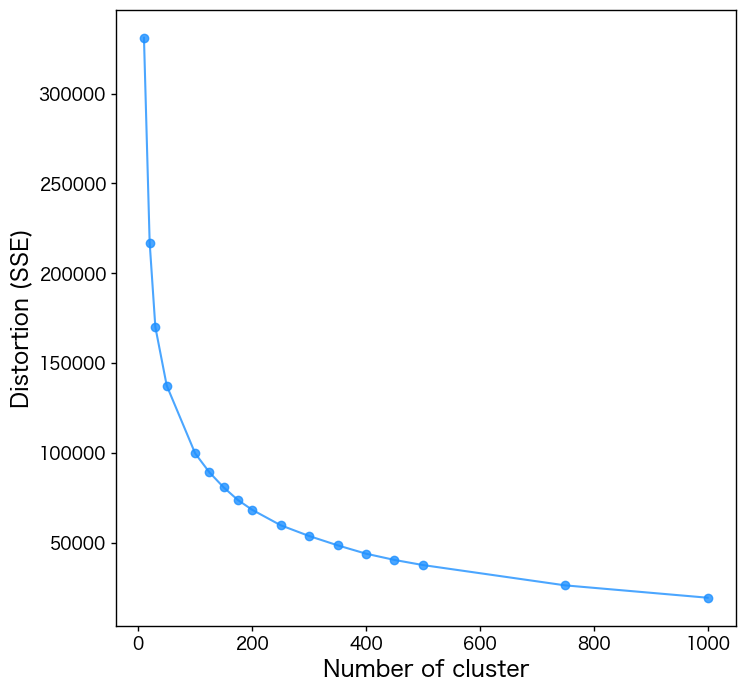

In [15]:
plt.figure(facecolor='white', figsize=(8, 8))
plt.plot(list(sse.keys()), list(sse.values()), marker='o', color='dodgerblue', alpha=0.8)
plt.xlabel("Number of cluster", fontsize=16)
plt.ylabel("Distortion (SSE)", fontsize=16)
plt.savefig('results/elbow_analysis.png', dpi=600, bbox_inches='tight')


For n_clusters = 100 The average silhouette_score is : 0.19669571718403575


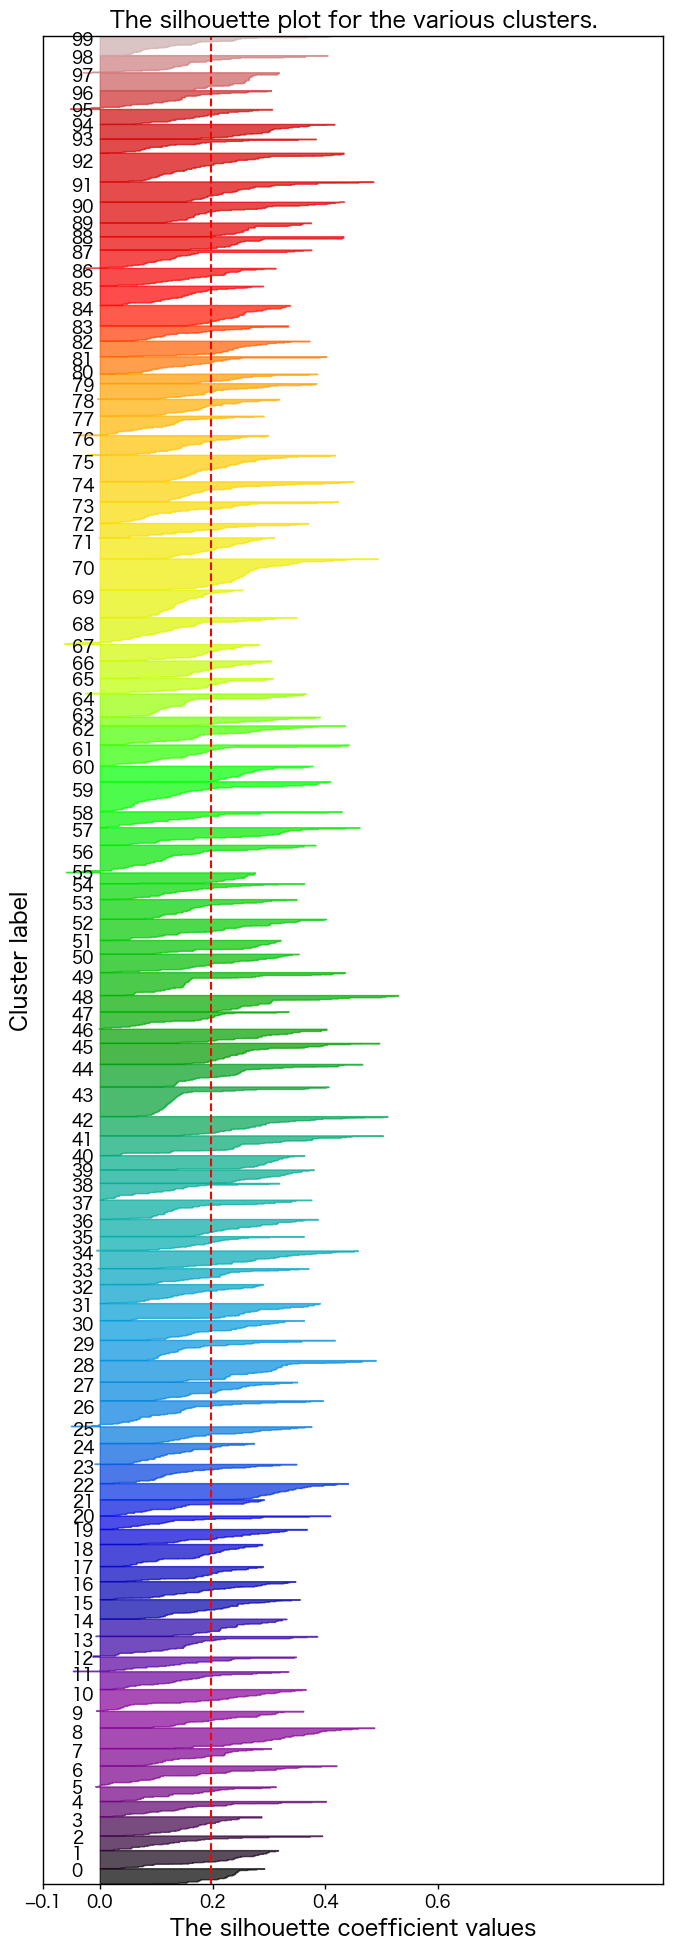

In [19]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

range_n_clusters = [100]
X = np.array(cand.loc[:, cand_wt_cols])
y = np.array(cand.loc[:, 'ei']).reshape(-1, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, facecolor='white', figsize=(8, 24))
    fig.set_size_inches(8, 24)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1107)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg
        )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, ith_cluster_silhouette_values,
            facecolor=color, edgecolor=color, alpha=0.7
            )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.", fontsize=16)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=16)
    ax1.set_ylabel("Cluster label", fontsize=16)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6])


    #plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
    #              "with n_clusters = %d" % n_clusters),
    #            fontsize=14, fontweight='bold')

    plt.savefig(f"results/silhouette_n_clusters_{i+1}.png", dpi=600, bbox_inches='tight')

In [16]:
cand

,Ad1,Ad1_wt%,Ad2,Ad2_wt%,Ad3,Ad3_wt%,Ad4,Ad4_wt%,Ad5,Ad5_wt%,ei,Top catal.,clusters
0,Mg,0.2,Rb,1.0,Nb,1.0,Te,0.0,Ta,0.0,0.063704,"Mg(0.2), Rb(1.0), Nb(1.0),",636
100,Na,0.2,Rb,1.0,Nb,1.0,Cd,0.0,Sb,0.2,0.084615,"Na(0.2), Rb(1.0), Nb(1.0), Sb(0.2),",636
105,Mg,0.2,Rb,1.0,Nb,1.0,Sb,0.0,Cs,0.2,0.081698,"Mg(0.2), Rb(1.0), Nb(1.0), Cs(0.2),",636
112,Na,0.2,Rb,1.0,Nb,1.0,In,0.0,Te,0.2,0.073836,"Na(0.2), Rb(1.0), Nb(1.0), Te(0.2),",636
118,Mg,0.2,Rb,1.0,Nb,1.0,Ag,0.0,Ba,0.2,0.067364,"Mg(0.2), Rb(1.0), Nb(1.0), Ba(0.2),",636
...,...,...,...,...,...,...,...,...,...,...,...,...,...
777595,Tb,1.0,Ho,1.5,Tm,2.0,Yb,2.0,Lu,2.0,0.015271,"Tb(1.0), Ho(1.5), Tm(2.0), Yb(2.0), Lu(2.0),",458
777596,Cs,1.0,Ce,1.5,Eu,2.0,Yb,2.0,W,2.0,0.015202,"Cs(1.0), Ce(1.5), Eu(2.0), Yb(2.0), W(2.0),",458
777597,Cs,1.0,Ba,1.5,Nd,2.0,Eu,2.0,W,2.0,0.015102,"Cs(1.0), Ba(1.5), Nd(2.0), Eu(2.0), W(2.0),",458
777598,Ce,1.0,Nd,1.5,Eu,2.0,Dy,2.0,Hf,2.0,0.015035,"Ce(1.0), Nd(1.5), Eu(2.0), Dy(2.0), Hf(2.0),",458


In [18]:
data

,No.,Ad1,Ad1_wt%,Ad2,Ad2_wt%,Ad3,Ad3_wt%,Ad4,Ad4_wt%,Ad5,Ad5_wt%,CO Yield_%,CO formation rate_mmol min-1 gcat-1,Iteration,Catal prep,Reaction,Note
0,1,Mo,10.0,H,0.0,H,0.0,H,0.0,H,0.0,3.065833,2.554000,0,Yamaguchi,Yamaguchi,NaN
1,2,V,10.0,H,0.0,H,0.0,H,0.0,H,0.0,2.475728,2.063107,0,Chen,Chen,NaN
2,3,Ce,10.0,H,0.0,H,0.0,H,0.0,H,0.0,2.447920,2.039933,0,Chen,Chen,NaN
3,4,La,10.0,H,0.0,H,0.0,H,0.0,H,0.0,1.777674,1.481395,0,Chen,Chen,NaN
4,5,Y,10.0,H,0.0,H,0.0,H,0.0,H,0.0,1.705534,1.421278,0,Chen,Chen,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,Mo,0.6,Ba,2.0,Re,1.2,W,0.2,H,0.0,3.944734,3.287278,44,Chen,Gang,NaN
296,297,Rb,1.0,Mo,0.5,Ba,1.0,Nb,0.2,Hf,0.2,3.830090,3.191742,44,Chen,Gang,NaN
297,298,Mo,0.7,Ba,0.5,K,0.7,W,0.2,H,0.0,3.444167,2.870139,44,Chen,Gang,NaN
298,299,Ce,0.2,Nb,0.2,Rb,1.2,Na,0.2,Mo,0.7,3.975253,3.312710,44,Chen,Gang,NaN


In [7]:
# 触媒候補データ(cand_sum)を読み込む関数
def read_cand(condition):
    date, Reaction = condition['date'], condition['Reaction']
    date, Reaction = condition['date'], condition['Reaction']
    pgm_num, prm_num = condition['pgm_num'], condition['prm_num']
    add_num, supp_num = condition['add_num'], condition['supp_num']
    pgm_model, prm_model = condition['pgm_model'], condition['prm_model']
    add_model, supp_model = condition['add_model'], condition['supp_model']

    # results_csv_file_all
    if pgm_num != 0 and prm_num != 0 and add_num != 0 and supp_num != 0:
        cand_file_name = f'results/{date}_{Reaction}_cand_sum_{ML_model}_prop{pgm_model}{prm_model}{add_model}{supp_model}_{Search_method}.csv'
    elif pgm_num != 0 and prm_num == 0 and add_num != 0 and supp_num != 0:
        cand_file_name = f'results/{date}_{Reaction}_cand_sum_{ML_model}_prop{pgm_model}{add_model}{supp_model}_{Search_method}.csv'
    elif pgm_num == 0 and prm_num == 0 and add_num != 0 and supp_num != 0:
        cand_file_name = f'results/{date}_{Reaction}_cand_sum_{ML_model}_prop{add_model}{supp_model}_{Search_method}.csv'
    elif pgm_num == 0 and prm_num == 0 and add_num != 0 and supp_num == 0:
        cand_file_name = f'results/{date}_{Reaction}_cand_sum_{ML_model}_prop{add_model}_{Search_method}.csv'

    data_cols = setting.data_columns(condition)
    cand_elem, cand_wt = data_cols['cand_elem'], data_cols['cand_wt']

    cand = converter.cand_separation(cand_file_name, condition)
    cand = converter.cand_str(cand, condition, data_cols)
    cand.drop_duplicates(subset=['Top catal.'], inplace=True)

    cand.loc[:, cand_elem] = cand.loc[:, cand_elem].fillna('H')
    cand.loc[:, cand_wt] = cand.loc[:, cand_wt].fillna(0)
    cand = cand.reset_index()
    return cand



# Descriptorファイルを読み込む
def read_desc(elem, condition, desc_cols, select_desc=True, local=False, standard=False):
    Reaction = condition['Reaction']
    pgm_num, prm_num = condition['pgm_num'], condition['prm_num']
    add_num, supp_num = condition['add_num'], condition['supp_num']
    elem_comp_list = [pgm_num, prm_num, add_num, supp_num]
    desc_file_name = 'data/Descriptors.xlsx'

    if elem != 'supp':
        desc_sheet_name = 'Descriptors_elem'
        use_desc = desc_cols['basic_desc_columns']
        desc = pd.read_excel(desc_file_name, sheet_name=desc_sheet_name, index_col='Symbol')
    else:
        desc_sheet_name = 'Descriptors_supp'
        use_desc = desc_cols['all_supp_desc']
        desc = pd.read_excel(
            desc_file_name, sheet_name=desc_sheet_name, index_col='Support_name')

    all_elems = list(desc.index)
    noble_gas = desc_cols['noble_gas']
    drop_elems = desc_cols['drop_elems']

    if elem == 'pgm':
        use_elem = desc_cols['pgm_plus_ReAu']
        if Reaction == 'N2O':
            desc = desc.loc[use_elem].drop('Os', axis=0)
        else:
            desc = desc.loc[use_elem].drop(['Re', 'Os'], axis=0)
        desc = desc[use_desc].fillna(desc.mean())
        if len(elem_comp_list) - elem_comp_list.count(0) != 1:
            desc = desc.rename(columns=lambda s: s+' (PGM)')
            aw = desc.loc[:, 'AW (PGM)']
        else:
            aw = desc.loc[:, 'AW']

    elif elem == 'prm':
        use_elem = ['H'] + desc_cols['prm_elems']
        desc = desc.loc[use_elem]
        desc = desc[use_desc].fillna(desc.mean())
        if len(elem_comp_list) - elem_comp_list.count(0) != 1:
            desc = desc.rename(columns=lambda s: s+' (Promoter)')
            aw = desc.loc[:, 'AW (Promoter)']
        else:
            aw = desc.loc[:, 'AW']

    elif elem == 'add':
        use_elem = [i for i in all_elems if i not in noble_gas+drop_elems]
        desc = desc.loc[use_elem]
        desc = desc[use_desc].fillna(desc.mean())
        if len(elem_comp_list) - elem_comp_list.count(0) != 1:
            desc = desc.rename(columns=lambda s: s+' (Additive)')
            aw = desc.loc[:, 'AW (Additive)']
        else:
            aw = desc.loc[:, 'AW']

    elif elem == 'supp':
        use_elem = desc.index[desc[Reaction] == 1]
        desc = desc.loc[use_elem]
        desc = desc[use_desc].replace('-', 0)
        desc = desc[use_desc].fillna(desc.mean())
        if len(elem_comp_list) - elem_comp_list.count(0) != 1:
            desc = desc.rename(columns=lambda s: s+' (Support)')
            aw = desc.loc[:, 'MW (Support)']
        else:
            aw = desc.loc[:, 'MW']

    elif elem == 'all':
        desc = desc[use_desc].fillna(desc.mean())
        aw = desc.loc[:, 'AW']

    if local == False:
        selec_desc = conditions.desc_select(Reaction)
    # else:
    #	selec_desc = desc_select(Reaction)

    if select_desc == True:
        if elem == 'pgm' and len(elem_comp_list) - elem_comp_list.count(0) != 1:
            selec_desc['use_'+elem] = [s + ' (PGM)' for s in selec_desc['use_'+elem]]
        if elem == 'prm' and len(elem_comp_list) - elem_comp_list.count(0) != 1:
            selec_desc['use_'+elem] = [s + ' (Promoter)' for s in selec_desc['use_'+elem]]
        if elem == 'add' and len(elem_comp_list) - elem_comp_list.count(0) != 1:
            selec_desc['use_'+elem] = [s + ' (Additive)' for s in selec_desc['use_'+elem]]
        if elem == 'supp' and len(elem_comp_list) - elem_comp_list.count(0) != 1:
            selec_desc['use_'+elem] = [s + ' (Support)' for s in selec_desc['use_'+elem]]
        if elem != 'all':
            desc = desc.loc[:, selec_desc['use_'+elem]]

    elif select_desc == False:
        if elem == 'pgm' and len(elem_comp_list) - elem_comp_list.count(0) != 1:
            selec_desc['drop_'+elem] = [s + ' (PGM)' for s in selec_desc['drop_'+elem]]
        if elem == 'prm' and len(elem_comp_list) - elem_comp_list.count(0) != 1:
            selec_desc['drop_'+elem] = [s + ' (Promoter)' for s in selec_desc['drop_'+elem]]
        if elem == 'add' and len(elem_comp_list) - elem_comp_list.count(0) != 1:
            selec_desc['drop_'+elem] = [s + ' (Additive)' for s in selec_desc['drop_'+elem]]
        if elem == 'supp' and len(elem_comp_list) - elem_comp_list.count(0) != 1:
            selec_desc['drop_'+elem] = [s + ' (Support)' for s in selec_desc['drop_'+elem]]
        if elem != 'all' and len(elem_comp_list) - elem_comp_list.count(0) != 1:
            desc = desc.drop(selec_desc['drop_'+elem], axis=1)
    desc = desc.dropna(how='all', axis=1)

    if standard == True:
        desc = (desc - desc.mean()) / desc.std(ddof=1)
    return desc, aw



# Feat.を定義する関数
def make_feat(elem, elem_num, model, data, desc, aw):
    if elem == 'PGM' or elem == 'Promoter' or elem == 'Ad':
        if elem_num != 0:
            feat_comp = pd.DataFrame(
                index=np.arange(len(data)), columns=desc.index)
            for i in range(len(data)):
                for j in range(elem_num):
                    feat_comp.loc[i, data.loc[i, f'{elem}{j+1}']] = data.loc[i, f'{elem}{j+1}_wt%']
            feat_comp = feat_comp.fillna(0)
            if 'H' in desc.index:
                feat_comp = feat_comp.drop('H', axis=1)
                feat_comp_cols = list(desc.index[1:])
            else:
                feat_comp_cols = list(desc.index)

            feat_desc = sum([
                np.multiply(np.array(desc.loc[data.loc[:, f"{elem}{i+1}"]]),
                            np.array(data[f"{elem}{i+1}_wt%"]).reshape(-1, 1)) /
                np.array(aw.loc[data.loc[:, f"{elem}{i+1}"]]).reshape(-1, 1) for i in range(elem_num)
            ])
            feat_desc_cols = list(desc.columns)

            if model == 0:
                feat = feat_comp
                feat_cols = feat_comp_cols
            elif model == 1:
                feat = np.hstack((feat_comp, feat_desc))
                feat_cols = list(feat_comp_cols) + list(feat_desc_cols)
            elif model == 2:
                feat = feat_desc
                feat_cols = feat_desc_cols
        else:
            feat, feat_cols = None, None

    elif elem == 'Supp':
        if elem_num != 0:
            feat_comp = pd.DataFrame(
                index=np.arange(len(data)), columns=desc.index)
            for i in range(len(data)):
                feat_comp.loc[i, data.loc[i, 'Support_name']] = 1
            feat_comp = feat_comp.fillna(0)
            feat_comp_cols = list(desc.index)

            feat_desc = desc.loc[data.loc[:, 'Support_name']]
            feat_desc = feat_desc.replace('-', 0)
            feat_desc_cols = list(desc.columns)

            if model == 0:
                feat = feat_comp
                feat_cols = feat_comp_cols
            elif model == 1:
                feat = np.hstack((feat_comp, feat_desc))
                feat_cols = list(feat_comp_cols) + list(feat_desc_cols)
            elif model == 2:
                feat = feat_desc
                feat_cols = feat_desc_cols
        else:
            feat, feat_cols = None, None

    elif elem == 'Calc T' or elem == 'Reaction T' or elem == 'WHSV (mL g-1 h-1)':
        if elem_num != 0:
            feat = np.array(data.loc[:, elem]).reshape(-1, 1)
            feat_cols = [elem]
        else:
            feat, feat_cols = None, None
    return feat, feat_cols



# datasetと DescriptorのExcelファイルを読み込み、feat, target等必要な形状に加工する。
def cand_convert(condition, data_cols, desc_cols, select_desc=True, use_models=[], local=False):
    cand_dict = {}

    cand = read_cand(condition)
    pgm_desc, pgm_aw = read_desc('pgm', condition, desc_cols, select_desc, local, standard=condition['desc_std'])
    prm_desc, prm_aw = read_desc('prm', condition, desc_cols, select_desc, local, standard=condition['desc_std'])
    add_desc, add_aw = read_desc('add', condition, desc_cols, select_desc, local, standard=condition['desc_std'])
    supp_desc, supp_mw = read_desc('supp', condition, desc_cols, select_desc, local, standard=condition['desc_std'])

    if len(use_models) == 0:
        pgm_model, prm_model = condition['pgm_model'], condition['prm_model']
        add_model, supp_model = condition['add_model'], condition['supp_model']
    elif len(use_models) == 1:
        add_model = use_models[0]
        pgm_model, prm_model, supp_model = 2, 2, 2
    elif len(use_models) == 2:
        add_model, supp_model = use_models[0], use_models[1]
        pgm_model, prm_model = 2, 2
    elif len(use_models) == 3:
        pgm_model, add_model, supp_model = use_models[0], use_models[1], use_models[2]
        prm_model = 2
    elif len(use_models) == 4:
        pgm_model, prm_model = use_models[0], use_models[1]
        add_model, supp_model = use_models[0], use_models[1]

    feat_pgm, feat_pgm_cols = make_feat('PGM', condition['pgm_num'], pgm_model, cand, pgm_desc, pgm_aw)
    feat_prm, feat_prm_cols = make_feat('Promoter', condition['prm_num'], prm_model, cand, prm_desc, prm_aw)
    feat_add, feat_add_cols = make_feat('Ad', condition['add_num'], add_model, cand, add_desc, add_aw)
    feat_supp, feat_supp_cols = make_feat('Supp', condition['supp_num'], supp_model, cand, supp_desc, supp_mw)
    feat_CalT, feat_CalT_cols = make_feat('Calc T', condition['CalT_num'], 0, cand, add_desc, add_aw)
    feat_ReacT, feat_ReacT_cols = make_feat('Reaction T', condition['ReacT_num'], 0, cand, add_desc, add_aw)
    feat_WHSV, feat_WHSV_cols = make_feat('WHSV (mL g-1 h-1)', condition['WHSV_num'], 0, cand, add_desc, add_aw)

    feat_list = [
        feat_pgm, feat_prm, feat_add,
        feat_supp, feat_CalT, feat_ReacT, feat_WHSV
    ]
    feat_cols_list = [
        feat_pgm_cols, feat_prm_cols, feat_add_cols, feat_supp_cols,
        feat_CalT_cols, feat_ReacT_cols, feat_WHSV_cols
    ]
    feat_list = [i for i in feat_list if i is not None]
    feat = np.hstack(feat_list)
    feat_cols_list = [i for i in feat_cols_list if i is not None]
    feat_cols = list(itertools.chain.from_iterable(feat_cols_list))
    #feat_cols = [item for row in feat_cols_list for item in row]
    feat = pd.DataFrame(feat, columns=feat_cols)
    target = cand.loc[:, 'ei']

    cand_dict = {
        'cand': cand,
        'pgm_desc': pgm_desc, 'prm_desc': prm_desc, 'add_desc': add_desc, 'supp_desc': supp_desc,
        'pgm_aw': pgm_aw, 'prm_aw': prm_aw, 'add_aw': add_aw, 'supp_mw': supp_mw,
        'feat': feat, 'target': target
        }
    return cand_dict

In [8]:
cand_dict = cand_convert(
	condition, data_cols, desc_cols,
    select_desc=True, use_models=[], local=False
	)
	
cand, feat, target = cand_dict['cand'], cand_dict['feat'], cand_dict['target']

cand_sep_data: (777600, 11)


In [9]:
model = ExtraTreesRegressor(n_estimators=condition['n_est'], random_state=1107, n_jobs=1)
model.fit(feat, target)


ExtraTreesRegressor(n_jobs=1, random_state=1107)

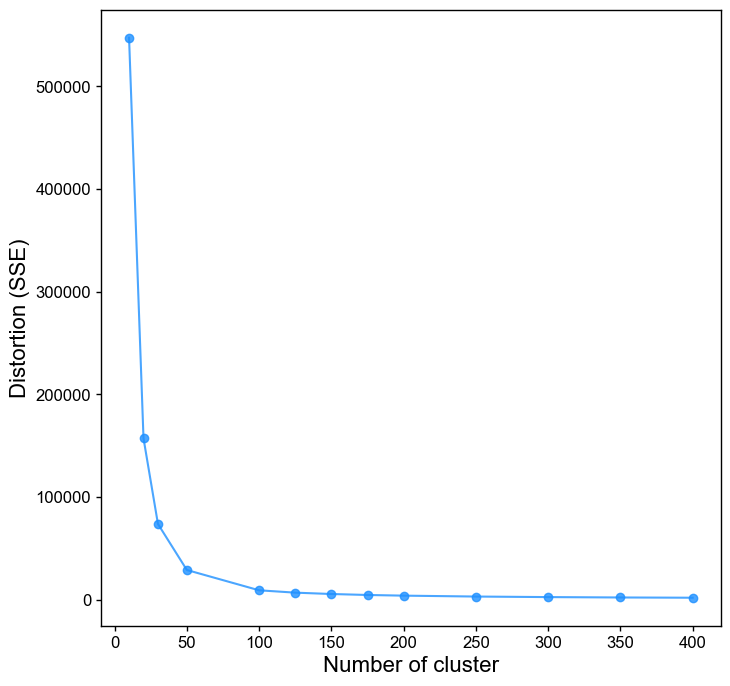

In [14]:
sse = {}
k_s = [
    10, 20, 30, 50, 100, 125, 150, 175, 200,
    250, 300, 350, 400,
    ]

for k in k_s:
    kmeans = KMeans(n_clusters=k).fit(feat)
    cand["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(facecolor='white', figsize=(8, 8))
plt.plot(list(sse.keys()), list(sse.values()), marker='o', color='dodgerblue', alpha=0.8)
plt.xlabel("Number of cluster", fontsize=16)
plt.ylabel("Distortion (SSE)", fontsize=16)
plt.savefig('results/elbow_analysis_cand_v2.png', dpi=600, bbox_inches='tight')


For n_clusters = 100 The average silhouette_score is : 0.4016113281093633


findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font family 'Hiragino sans' not found.
findfont: Font famil

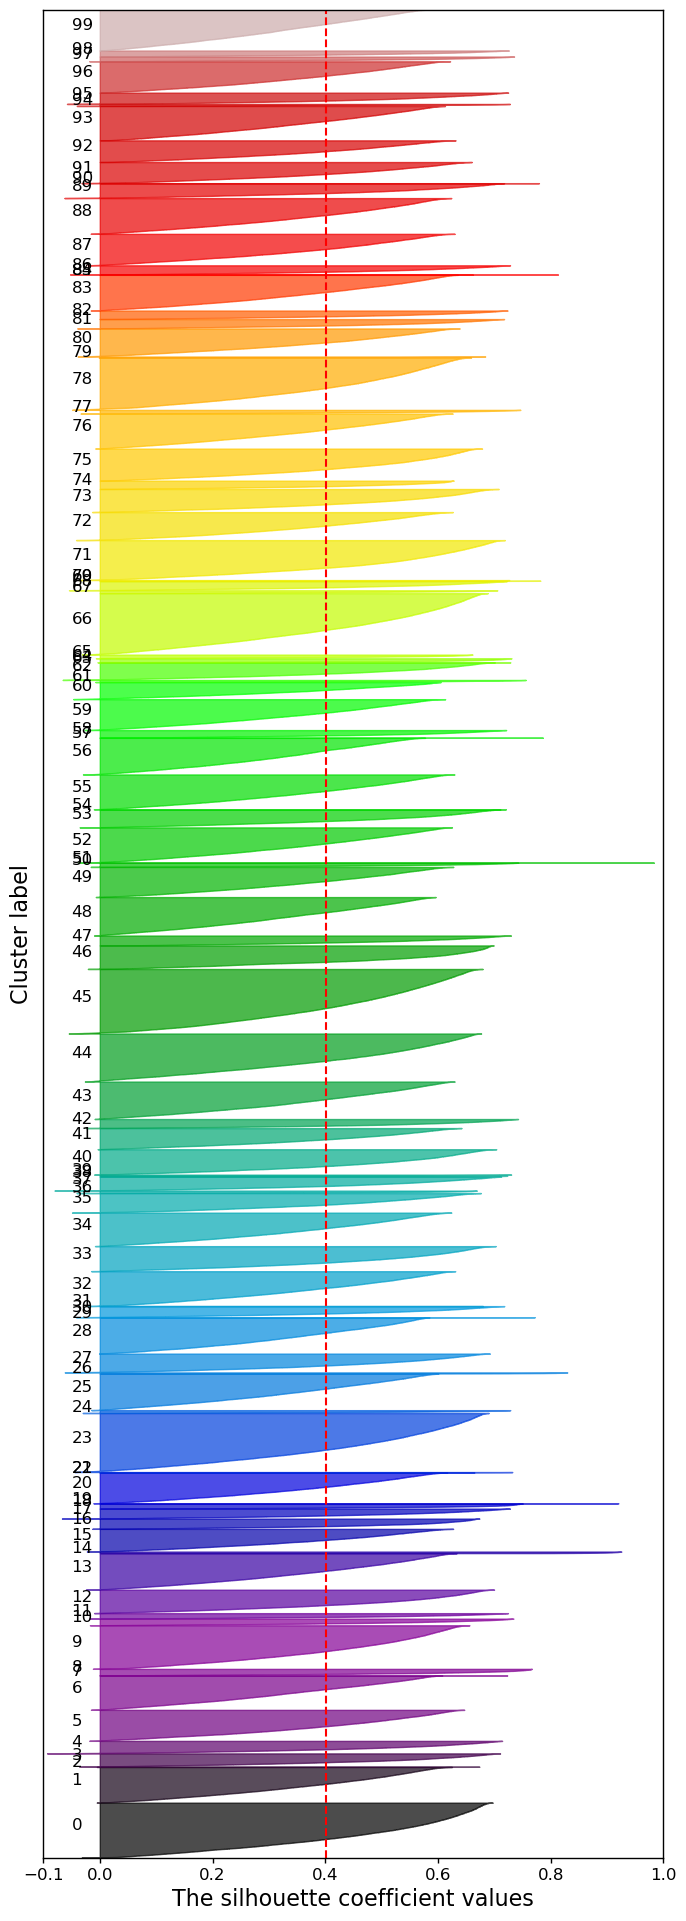

In [11]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

range_n_clusters = [100]
X = np.array(feat)
y = np.array(target).reshape(-1, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, facecolor='white', figsize=(8, 24))
    fig.set_size_inches(8, 24)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1.0])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1107)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, ith_cluster_silhouette_values,
            facecolor=color, edgecolor=color, alpha=0.7
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.", fontsize=16)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=16)
    ax1.set_ylabel("Cluster label", fontsize=16)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1.0])

    #plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
    #              "with n_clusters = %d" % n_clusters),
    #            fontsize=14, fontweight='bold')

    plt.savefig(f"results/silhouette_n_clusters_{i+1}.png", dpi=600, bbox_inches='tight')
